# Feature Engineering

## Strategy

1. **Date and Time Features:** We can extract various date and time features such as day of week, day of month, hour, and minute from the `TransactionStartTime` column. These features might help us capture any patterns in fraudulent transactions that occur during specific times of the day or days of the week.

2. **Categorical Features:** We can one-hot encode the categorical features such as `ProductCategory`, `ChannelId`, `ProviderId`, and `PricingStrategy` to convert them into a numerical representation that our AI model can understand.

3. **Amount Features:** We can create new features based on the `Amount` column such as the mean and standard deviation of transactions for each `AccountId`, `SubscriptionId`, `CustomerId`, `ProviderId`, `ProductCategory`, and `ChannelId`. These features might help us identify any abnormal transaction patterns for specific users, products, or providers.

4. **Fraudulent Account and Subscription:** We can create a new feature that indicates if an `AccountId` or `SubscriptionId` has previously been involved in a fraudulent transaction.

5. **Transaction Frequency:** We can create a new feature that indicates the **frequency of transactions** for each `AccountId`, `SubscriptionId`, `CustomerId`, `ProviderId`, `ProductCategory`, and `ChannelId`. These features might help us identify any abnormal transaction patterns for specific users, products, or providers.

6. **Amount Deviation:** We can create a new feature that indicates the **deviation** of an Amount from the average Amount for each `AccountId`, `SubscriptionId`, `CustomerId`, `ProviderId`, `ProductCategory`, and `ChannelId`. This feature might help us identify any transactions with abnormally high or low amounts.

7. **Account Balance:** We can create a new feature that indicates the **balance** of each `AccountId` after each transaction. This feature might help us identify any abnormal account balances after specific transactions.

8. **Expense Transaction** We can create a new feature that indicates the wether the transaction is an expense or not.

9. **Interaction Features:** We can create interaction features between different columns such as `ProductCategory` and `ProviderId`. These features might help us capture any patterns that arise from the interaction between different categories.

10. **Bin Numeric Features:** We can bin numeric features such as `Amount` into discrete intervals and use them as categorical features. This might help us capture any patterns that arise from specific ranges of Amounts.

In [209]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from datetime import datetime

In [210]:
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
df = pd.read_csv("input/training.csv")
data = df.drop("FraudResult", axis=1)
y_train = df["FraudResult"]
X_test = pd.read_csv("input/test.csv")
X_valid = X_test.copy()
sample_submission = pd.read_csv("input/sample_submission.csv")

# 0. Preprocessing

In [211]:
# Create Expense feature
data["Expense"] = data["Amount"] < 0
data = data.drop("Amount", axis=1)

X_test["Expense"] = X_test["Amount"] < 0
X_test = X_test.drop("Amount", axis=1)

In [212]:
# Create StandardScaler object
scaler = StandardScaler()

# Normalize selected columns
data["Value"] = scaler.fit_transform(data["Value"].values.reshape(-1, 1))
X_test["Value"] = scaler.fit_transform(X_test["Value"].values.reshape(-1, 1))

# Show the normalized values
data[["Value", "Expense"]].head()

,Value,Expense
0,-0.072291,False
1,-0.080251,True
2,-0.076352,False
3,0.096648,False
4,-0.075183,True


In [213]:
# Count the number of unique entries in each column
unique_counts = data.nunique()

# Select only columns with more than one unique entry
drop_cols = unique_counts[unique_counts == 1].index.tolist()
print("Dropping column with one unique values: ", drop_cols)

# Drop the selected columns
data = data.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)


# Count unique entries in each column
unique_counts = data.nunique()
print("\nResulting data:")
print(unique_counts)

Dropping column with one unique values:  ['CurrencyCode', 'CountryCode']

Resulting data:
TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
Expense                     2
dtype: int64


After some observation, column with dtype `object` that contains the word `Id` in their name contains as entries strings of number with the following structure:  `ColumnNameId_X` where `X` is a numerical value.

We can therefore replace those string entry by their numeric value and then convert the column dtype into `int32`.

In [214]:
# Get a list of column names that contain the string "id" in their name
id_cols = data.filter(like="Id").columns.tolist()

# Print the list of column names
print("Converting columns with Id: ", id_cols)

# Remove column name prefix and convert to integer data type
data[id_cols] = (
    data[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)
X_test[id_cols] = (
    X_test[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)

data.head()

Converting columns with Id:  ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,Expense
0,76871,36123,3957,887,4406,6,10,airtime,3,-0.072291,2018-11-15T02:18:49Z,2,False
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-0.080251,2018-11-15T02:19:08Z,2,True
2,26203,53941,4229,222,4683,6,1,airtime,3,-0.076352,2018-11-15T02:44:21Z,2,False
3,380,102363,648,2185,988,1,21,utility_bill,3,0.096648,2018-11-15T03:32:55Z,2,False
4,28195,38780,4841,3829,988,4,6,financial_services,2,-0.075183,2018-11-15T03:34:21Z,2,True


## 1. Date and Time Features

In [215]:
# convert TransactionStartTime column to datetime format
data["TransactionStartTime"] = pd.to_datetime(
    df["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)
X_test["TransactionStartTime"] = pd.to_datetime(
    X_test["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)

# extract date and time features
data["TransactionDayOfWeek"] = data["TransactionStartTime"].dt.dayofweek
data["TransactionDayOfMonth"] = data["TransactionStartTime"].dt.day
data["TransactionHour"] = data["TransactionStartTime"].dt.hour
data["TransactionMinute"] = data["TransactionStartTime"].dt.minute

X_test["TransactionDayOfWeek"] = X_test["TransactionStartTime"].dt.dayofweek
X_test["TransactionDayOfMonth"] = X_test["TransactionStartTime"].dt.day
X_test["TransactionHour"] = X_test["TransactionStartTime"].dt.hour
X_test["TransactionMinute"] = X_test["TransactionStartTime"].dt.minute

# drop TransactionStartTime
data = data.drop("TransactionStartTime", axis=1)
X_test = X_test.drop("TransactionStartTime", axis=1)

# Show the new features
data[
    [
        "TransactionDayOfWeek",
        "TransactionDayOfMonth",
        "TransactionHour",
        "TransactionMinute",
    ]
].head()

,TransactionDayOfWeek,TransactionDayOfMonth,TransactionHour,TransactionMinute
0,3,15,2,18
1,3,15,2,19
2,3,15,2,44
3,3,15,3,32
4,3,15,3,34


## 2. Categorical Features

In [216]:
# Select the categorical columns to one-hot encode
cat_cols = ["ProductCategory", "ChannelId", "ProviderId", "PricingStrategy"]
# for col in cat_cols:
#     print(data[col].unique())
#     print(X_test[col].unique())

# One-hot encode the categorical columns
data = pd.get_dummies(data, columns=cat_cols)
data["ChannelId_4"] = False
data["ProductCategory_retail"] = False
X_test = pd.get_dummies(X_test, columns=cat_cols)
X_test["ProductCategory_other"] = False

# Show the new features
new_columns = [col for col in data.columns if col.startswith(tuple(cat_cols))]
data[new_columns].head()

,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_1,...,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,ChannelId_4,ProductCategory_retail
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


## 3. Amount Features

In [217]:
mean_amount_features = ["AccountId", "SubscriptionId"]
std_amount_features = [
    "ProductCategory_airtime",
    "ProductCategory_data_bundles",
    "ProductCategory_financial_services",
    "ProductCategory_movies",
    "ProductCategory_other",
    "ProductCategory_ticket",
    "ProductCategory_transport",
    "ProductCategory_tv",
    "ProductCategory_utility_bill",
    "ProductCategory_retail",
    "ProductCategory_other",
    "ChannelId_1",
    "ChannelId_2",
    "ChannelId_3",
    "ChannelId_4",
    "ChannelId_5",
    "ProviderId_1",
    "ProviderId_2",
    "ProviderId_3",
    "ProviderId_4",
    "ProviderId_5",
    "ProviderId_6",
    "PricingStrategy_0",
    "PricingStrategy_1",
    "PricingStrategy_2",
    "PricingStrategy_4",
]

In [218]:
# Create new features based on the 'Amount' column
for feature in mean_amount_features:
    # Compute the mean and standard deviation of transactions for each feature
    data[f"{feature}_mean_amount"] = data.groupby(feature)["Value"].transform("mean")
    X_test[f"{feature}_mean_amount"] = X_test.groupby(feature)["Value"].transform(
        "mean"
    )
for feature in std_amount_features:
    data[f"{feature}_std_amount"] = data.groupby(feature)["Value"].transform("std")
    X_test[f"{feature}_std_amount"] = X_test.groupby(feature)["Value"].transform("std")


# Show the new features
data.filter(like="amount").head()

,AccountId_mean_amount,SubscriptionId_mean_amount,ProductCategory_airtime_std_amount,ProductCategory_data_bundles_std_amount,ProductCategory_financial_services_std_amount,ProductCategory_movies_std_amount,ProductCategory_other_std_amount,ProductCategory_ticket_std_amount,ProductCategory_transport_std_amount,ProductCategory_tv_std_amount,...,ProviderId_1_std_amount,ProviderId_2_std_amount,ProviderId_3_std_amount,ProviderId_4_std_amount,ProviderId_5_std_amount,ProviderId_6_std_amount,PricingStrategy_0_std_amount,PricingStrategy_1_std_amount,PricingStrategy_2_std_amount,PricingStrategy_4_std_amount
0,-0.061107,-0.061107,0.181176,1.008441,0.218949,1.000918,1.000016,1.000209,0.998996,1.005925,...,0.632924,1.000099,0.945802,1.285965,0.950563,0.086240,0.910628,1.008272,0.988251,1.075461
1,-0.073117,-0.073073,1.363250,1.008441,1.432772,1.000918,1.000016,1.000209,0.998996,1.005925,...,0.632924,1.000099,0.945802,0.111059,0.950563,1.244939,0.910628,1.008272,0.988251,1.075461
2,-0.076352,-0.076352,0.181176,1.008441,0.218949,1.000918,1.000016,1.000209,0.998996,1.005925,...,0.632924,1.000099,0.945802,1.285965,0.950563,0.086240,0.910628,1.008272,0.988251,1.075461
3,0.002166,0.002166,1.363250,1.008441,0.218949,1.000918,1.000016,1.000209,0.998996,1.005925,...,3.237497,1.000099,0.945802,1.285965,0.950563,1.244939,0.910628,1.008272,0.988251,1.075461
4,-0.073117,-0.073073,1.363250,1.008441,1.432772,1.000918,1.000016,1.000209,0.998996,1.005925,...,0.632924,1.000099,0.945802,0.111059,0.950563,1.244939,0.910628,1.008272,0.988251,1.075461


## 4. Fraudulent Account and Subscription

This code groups the data by `AccountId` and `SubscriptionId` using `groupby()` and then uses `transform()` to apply a rolling sum of the FraudResult column. The rolling sum is calculated using `shift()` to shift the FraudResult column by one row and `rolling()` to apply a rolling window of the length of the group. Finally, `> 0` is used to convert the rolling sum to a boolean value indicating if the `AccountId` or `SubscriptionId` has been involved in fraud in the past. This new column is added to the original dataframe as Fraudulent_Account.

In [219]:
# # Group the data by AccountId and SubscriptionId
# grouped_data = df.groupby(['AccountId', 'SubscriptionId'])

# # Create a new column to indicate if the AccountId or SubscriptionId has been involved in fraud
# data['Fraudulent_Account'] = grouped_data['FraudResult'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum() > 0)

# # Show the new feature
# data[['AccountId', 'SubscriptionId', 'FraudResult', 'Fraudulent_Account']].head()

**Note:**

A **rolling window** is a commonly used technique in time series analysis and data processing, where a window of fixed length is applied to a sequence of data points, and a calculation is performed on the data within the window. The window is then shifted one data point forward, and the calculation is repeated for the new window. This process is repeated until the window has traversed the entire sequence.

For example, if we have a time series data of daily stock prices, and we want to calculate a moving average of the prices over a 5-day period, we can use a rolling window of 5 days. We would start with the first 5 days of prices, calculate the average, and record it as the average for the first 5-day period. We would then shift the window by one day, and calculate the average for the next 5-day period, and so on. This would give us a new moving average value for every 5-day period in the sequence.

In the context of the code snippet provided earlier, a rolling window is used to calculate a rolling sum of the FraudResult column over the length of the group, shifted by one row. This helps to identify if an `AccountId` or `SubscriptionId` has been involved in a fraudulent transaction in the past, which is a useful feature for predicting future fraud.

## 5. Train and Predict

In [220]:
def fit_models_and_predict(X_train, X_valid):
    # Fit and evaluate the models
    models = {
        # 'Linear Regression': LinearRegression(random_state=1),
        # 'Logistic Regression': LogisticRegression(random_state=1),
        "Decision Trees": DecisionTreeRegressor(random_state=1),
        "Random Forests": RandomForestRegressor(n_estimators=10, random_state=1),
        "Gradient Boosting": XGBRegressor(
            n_estimators=1000, learning_rate=0.05, n_jobs=4, random_state=1
        ),
    }

    for model_name, model in models.items():
        print(f"Fitting {model_name}")
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        sample_submission["FraudResult"] = predictions
        # Export data to csv
        current_datetime = datetime.now()
        timestamp = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{model_name}_{timestamp}.csv"
        sample_submission.to_csv(filename, index=False)


# Get the order of columns in the first dataset
column_order = data.columns

# Reorder the columns in the second dataset based on the column_order
X_test = X_test.reindex(columns=column_order)

# fit_models_and_predict(data, X_test)

In [221]:
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

/var/folders/83/hq1n6grd4cggpptg4t4wgw1c0000gn/T/ipykernel_2370/3904845510.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [222]:
# Create StandardScaler object
scaler = StandardScaler()

# # Normalize selected columns
# df["Value"] = scaler.fit_transform(df["Value"].values.reshape(-1, 1))

# Create Expense feature
df["Expense"] = df["Amount"] < 0
df = df.drop("Amount", axis=1)
X_valid["Expense"] = X_valid["Amount"] < 0
X_valid = X_valid.drop("Amount", axis=1)

# Count the number of unique entries in each column
unique_counts = df.nunique()

# Select only columns with more than one unique entry
drop_cols = unique_counts[unique_counts == 1].index.tolist()
print("Dropping column with one unique values: ", drop_cols)

# Drop the selected columns
df = df.drop(columns=drop_cols, axis=1)
X_valid = X_valid.drop(columns=drop_cols, axis=1)

# Get a list of column names that contain the string "id" in their name
id_cols = df.filter(like="Id").columns.tolist()

# Print the list of column names
print("Converting columns with Id: ", id_cols)

# Remove column name prefix and convert to integer data type
df[id_cols] = (
    df[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)
X_valid[id_cols] = (
    X_valid[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)

# convert TransactionStartTime column to datetime format
df["TransactionStartTime"] = pd.to_datetime(
    df["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)
X_valid["TransactionStartTime"] = pd.to_datetime(
    X_valid["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)

# extract date and time features
df["TransactionDayOfWeek"] = df["TransactionStartTime"].dt.dayofweek
df["TransactionDayOfMonth"] = df["TransactionStartTime"].dt.day
df["TransactionHour"] = df["TransactionStartTime"].dt.hour
df["TransactionMinute"] = df["TransactionStartTime"].dt.minute

X_valid["TransactionDayOfWeek"] = X_valid["TransactionStartTime"].dt.dayofweek
X_valid["TransactionDayOfMonth"] = X_valid["TransactionStartTime"].dt.day
X_valid["TransactionHour"] = X_valid["TransactionStartTime"].dt.hour
X_valid["TransactionMinute"] = X_valid["TransactionStartTime"].dt.minute

# drop TransactionStartTime
df = df.drop("TransactionStartTime", axis=1)
X_valid = X_valid.drop("TransactionStartTime", axis=1)

# Factorize the "ProductCategory" column
df['ProductCategory'] = pd.factorize(df['ProductCategory'])[0] + 1
X_valid['ProductCategory'] = pd.factorize(df['ProductCategory'])[0] + 1

# Convert the "ProductCategory" column to integer data type
df['ProductCategory'] = df['ProductCategory'].astype(int)
X_valid['ProductCategory'] = X_valid['ProductCategory'].astype(int)



Dropping column with one unique values:  ['CurrencyCode', 'CountryCode']
Converting columns with Id:  ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']


ValueError: Length of values (95662) does not match length of index (45019)

In [ ]:
for col in df.columns.to_list():
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
for col in X_valid.columns.to_list():
    X_valid[col] = scaler.fit_transform(X_valid[col].values.reshape(-1, 1))

In [197]:
# df.columns
mean_amount_features = ["AccountId", "SubscriptionId"]
std_amount_features = ["ProductCategory", "ChannelId", "PricingStrategy", "ProviderId"]
for feature in mean_amount_features:
    # Compute the mean and standard deviation of transactions for each feature
    df[f"{feature}_mean_amount"] = df.groupby(feature)["Value"].transform("mean")
for feature in std_amount_features:
    df[f"{feature}_std_amount"] = df.groupby(feature)["Value"].transform("std")

In [198]:
kmeans = KMeans(n_clusters=6)
df["Cluster"] = kmeans.fit_predict(df)
# X_test["Cluster"] = kmeans.fit_predict(X_test)

df["Cluster"] = df["Cluster"].astype("category")
# X_test["Cluster"] = X_test["Cluster"].astype("category")

/Users/nmi/miniforge3/envs/AI5L/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


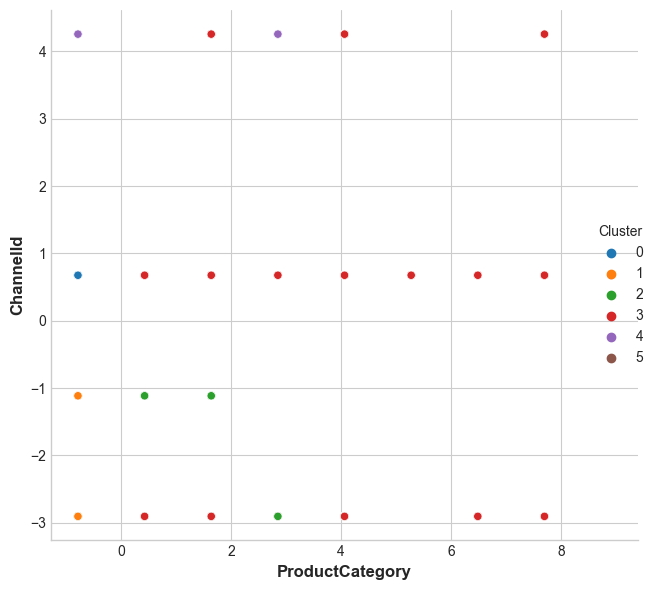

In [199]:
sns.relplot(
    x="ProductCategory", y="ChannelId", hue="Cluster", data=df, height=6,
)

In [200]:
df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Value',
       'PricingStrategy', 'FraudResult', 'Expense', 'TransactionDayOfWeek',
       'TransactionDayOfMonth', 'TransactionHour', 'TransactionMinute',
       'AccountId_mean_amount', 'SubscriptionId_mean_amount',
       'ProductCategory_std_amount', 'ChannelId_std_amount',
       'PricingStrategy_std_amount', 'ProviderId_std_amount', 'Cluster'],
      dtype='object')

In [208]:
rdf_model = RandomForestRegressor(n_estimators=10, random_state=1)
y_train = df["FraudResult"]
X_train = df.drop("FraudResult", axis=1)
rdf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [208]:
# # Create new frequency features for each group
# group_cols = [
#     "AccountId",
#     "SubscriptionId",
#     "CustomerId",
#     "ProviderId",
#     "ProductCategory",
#     "ChannelId",
# ]
# for col in group_cols:
#     freq_col = col + "_freq"
#     data[freq_col] = df.groupby(col)["TransactionId"].transform("count")

# # Show the new features
# data.filter(like="_freq").head()